In [1]:
import pandas as pd

from bs4 import BeautifulSoup
from urllib.error import HTTPError, URLError
from urllib.request import Request,urlopen
from selenium import webdriver

import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import gspread
import pygsheets
from oauth2client.service_account import ServiceAccountCredentials
from pprint import pprint

import re
import time
from time import sleep
from random import randint
import json


from jyquickhelper import add_notebook_menu


<h2> <font color='green'> <strong> Indíce </strong> </font> </h2>

In [2]:
add_notebook_menu(menu_id="main_menu")

<h2> <font color='green'> <strong> Funções </strong> </font> </h2>

In [3]:
# Remover repetição em listas

def RemoveRepeater(lista):
    l = []
    for i in lista:
        if i not in l:
            l.append(i)
    l.sort()
    return l

# Validação de request Urlopen

def OpenUrl(url):
    try:
        link= urlopen(url)
    except HTTPError as H_Error:
        print(H_Error)
    except URLError as U_Error:
        print(f'URL não funciona = {url}')
    else:
        print(f'URL funciona = {url}')
    try:
        soup= BeautifulSoup(link.read(), 'lxml')
    except:
        print('conteúdo não encontrado')
    return soup

# User and Password

with open('credsface.json', "r") as credsface:
    info = json.load(credsface)
    
users = info["email"]
passwords = info["password"]


<h2> <font color='green'> <strong> Acessando o Facebook - Versão Mbasic </strong> </font> </h2>


In [14]:

# Step 1) Abrindo o Chrome

driver = webdriver.Chrome("../chromedriver 4")


# Step 2) Navegando para o Login do Facebook

driver.get("https://mbasic.facebook.com/")
time.sleep(3)


# Step 3) Campos para o Email e Password

username = driver.find_element_by_id("m_login_email")
password = driver.find_element_by_xpath('//*[@id="login_form"]/ul/li[2]/div/input')
submit   = driver.find_element_by_xpath('//*[@id="login_form"]/ul/li[3]/input')


# Step 4) Acessando o arquivo de credenciais 

username.send_keys(users)
password.send_keys(passwords)
submit.click()

# Step 5) Pulando Step de Login

submit1  = driver.find_element_by_xpath('//*[@id="root"]/table/tbody/tr/td/div/div[3]/a')
time.sleep(3)
submit1.click()

# Step 6) Acessando o Perfil do Facebook

click1 = driver.find_element_by_xpath('//*[@id="header"]/div/a[2]')
click1.click()
time.sleep(3)


<h2> <font color='green'> <strong> Transformando em SOUP para extrair as TAGs </strong> </font> </h2>

In [5]:

# Step 7) Transformando o HTML em soup

soup = BeautifulSoup(driver.page_source, 'html.parser') 

# Step 8) Abrindo arquivo com posts já extraídos

lst_href = []
lst_texto = []

df_href_check_in = pd.read_csv('lst_href.csv')  

# Step 9) Buscando as tags com href dos posts novos

tag_a = soup.find_all('a',{'href': re.compile('(\/story\.php.*AW-R)')})

for row in tag_a:
    href = row.get('href')

# Step 10) Eliminando duplicações e erros

    regex = '#footer_action_list'
    if re.search(regex, href) == None:
        lst_href.append(href)

lst_href = RemoveRepeater(lst_href)

for i in df_href_check_in.href:
    for f in lst_href:
        if i == f:
            lst_href.remove(f)
            
# Step 12) Criando nova DF com novos hrefs

df_append = pd.DataFrame(lst_href,columns=['href'])

df_append 

,href
0,/story.php?story_fbid=2815825325203816&id=1000...
1,/story.php?story_fbid=2815829185203430&id=1000...
2,/story.php?story_fbid=2815829438536738&id=1000...
3,/story.php?story_fbid=2815839405202408&id=1000...
4,/story.php?story_fbid=2816890755097273&id=1000...


<h2> <font color='green'> <strong> Transformando o texto em URL para o post </strong> </font> </h2>

In [6]:
# Step 11) Criando Url do Post

df_append['link'] = str

for k,v in df_append['href'].items():
    regex_search = re.search("story_fbid=(.*)&id", v)
    texto_match = 'https://mbasic.facebook.com/'+ regex_search.group(1)
    df_append.link[k] = texto_match

    
df_append

,href,link
0,/story.php?story_fbid=2815825325203816&id=1000...,https://mbasic.facebook.com/2815825325203816
1,/story.php?story_fbid=2815829185203430&id=1000...,https://mbasic.facebook.com/2815829185203430
2,/story.php?story_fbid=2815829438536738&id=1000...,https://mbasic.facebook.com/2815829438536738
3,/story.php?story_fbid=2815839405202408&id=1000...,https://mbasic.facebook.com/2815839405202408
4,/story.php?story_fbid=2816890755097273&id=1000...,https://mbasic.facebook.com/2816890755097273


<h2> <font color='green'> <strong> Extraindo a TAG da URL do Post </strong> </font> </h2>

In [7]:
df_append['texto'] = str

for k,v in df_append['link'].items():
    driver.get(f"{v}")
    time.sleep(5)
    soup_tag = BeautifulSoup(driver.page_source, 'html.parser')
    tag_title = soup_tag.title.string
    df_append.texto[k] = tag_title

df_append

,href,link,texto
0,/story.php?story_fbid=2815825325203816&id=1000...,https://mbasic.facebook.com/2815825325203816,praticidade e funcionalidade que essa ferramen...
1,/story.php?story_fbid=2815829185203430&id=1000...,https://mbasic.facebook.com/2815829185203430,o que é bem ilegível e talvez você não note qu...
2,/story.php?story_fbid=2815829438536738&id=1000...,https://mbasic.facebook.com/2815829438536738,sendo meio óbvio falando sobre Series e DataFr...
3,/story.php?story_fbid=2815839405202408&id=1000...,https://mbasic.facebook.com/2815839405202408,TESTE - Pandas é a minha biblioteca favorita d...
4,/story.php?story_fbid=2816890755097273&id=1000...,https://mbasic.facebook.com/2816890755097273,2 > o que me fazia criar uma série de loop for...


<h2> <font color='green'> <strong> Mesclando a nova DF com as informações coletadas </strong> </font> </h2>

In [8]:
# Step 13) Concatenando Nova DF com DF existente

union_df = pd.concat([df_href_check_in, df_append], axis=0, keys=['href','link','texto'], ignore_index=True)

# Step 14) Salvando arquivos concatenados

union_df.to_csv('lst_href.csv', index=False)

# Step 15) Lendo novamente o arquivo salvo

df_href_check_out = pd.read_csv('lst_href.csv')  
df_href_check_out

,href,link,texto
0,/story.php?story_fbid=2815825325203816&id=1000...,https://mbasic.facebook.com/2815825325203816,praticidade e funcionalidade que essa ferramen...
1,/story.php?story_fbid=2815829185203430&id=1000...,https://mbasic.facebook.com/2815829185203430,o que é bem ilegível e talvez você não note qu...
2,/story.php?story_fbid=2815829438536738&id=1000...,https://mbasic.facebook.com/2815829438536738,sendo meio óbvio falando sobre Series e DataFr...
3,/story.php?story_fbid=2815839405202408&id=1000...,https://mbasic.facebook.com/2815839405202408,TESTE - Pandas é a minha biblioteca favorita d...
4,/story.php?story_fbid=2816890755097273&id=1000...,https://mbasic.facebook.com/2816890755097273,2 > o que me fazia criar uma série de loop for...
5,/story.php?story_fbid=10212576253360762&id=181...,https://mbasic.facebook.com/10212576253360762,Non basterà un semplice mese di lockdown globa...
6,/story.php?story_fbid=205403257426561&id=10003...,https://mbasic.facebook.com/205403257426561,"Não é só a mudança de visual,é mudança de vida.."
7,/story.php?story_fbid=2601299736794055&id=1000...,https://mbasic.facebook.com/2601299736794055,Amor meu ❤...
8,/story.php?story_fbid=3203768979848251&id=1000...,https://mbasic.facebook.com/3203768979848251,Com muita tristeza e pesar no coração que venh...
9,/story.php?story_fbid=2815825325203816&id=1000...,https://mbasic.facebook.com/2815825325203816,praticidade e funcionalidade que essa ferramen...


<h2> <font color='green'> <strong> Atualizando a planilha Google Spreadsheet </strong> </font> </h2>

In [9]:

scope = [
"https://www.googleapis.com/auth/drive",
"https://www.googleapis.com/auth/drive.readonly",
"https://www.googleapis.com/auth/drive.file",
"https://www.googleapis.com/auth/spreadsheets",
"https://www.googleapis.com/auth/spreadsheets.readonly"
]


creds = ServiceAccountCredentials.from_json_keyfile_name("creds.json", scope)
client = gspread.authorize(creds)
sheet = client.open("API").sheet1
data = sheet.get_all_values()


<h2> <font color='green'> <strong> Funções para o Spreadsheet </strong> </font> </h2>

In [10]:


def iter_pd(df):
    for val in df.columns:
        yield val
    for row in df.to_numpy():
        for val in row:
            if pd.isna(val):
                yield ""
            else:
                yield val

# Função Update a partir da última linha preenchida
                
def df_for_sheets(pandas_df, sheet, clear = False):
    if clear:
        sheet.clear()
    (row, col) = pandas_df.shape
    data_shape = len(sheet.get_all_values()) + 1
    val_shape = gspread.utils.rowcol_to_a1(row + 1 + data_shape, col)
    cells = sheet.range(f"A{data_shape}:{val_shape}")
    for cell, val in zip(cells, iter_pd(pandas_df)):
        cell.value = val
        sheet.update_cells(cells)


<h2> <font color='green'> <strong> Atualizando Spreadsheet </strong> </font> </h2>

In [11]:
# Atualizando planilha com novas informações

df_for_sheets(df_append, sheet, clear = True)

# Coletando histórico de textos

col_text = [str(i) for i in sheet.get("C2:C")]


<h2> <font color='green'> <strong> Nuvem de Palavras a partir do texto coletado nos Posts </strong> </font> </h2>

In [12]:
# Limpeza de caracteres indesejados

def repl_pont(lst_del, val):
    text_repl = ""
    if val in lst_del:
        text_repl = " "
    else:
        text_repl = val
    return text_repl

# Agrupamento do texto em DataFrame.Columns

def UnionText(df_text):
    espace = " "
    text = ""
    for row in df_text:
        for i in row.split():
            tx_repl = repl_pont(repl_lst, i)
            text += tx_repl + espace
    return text.lower()




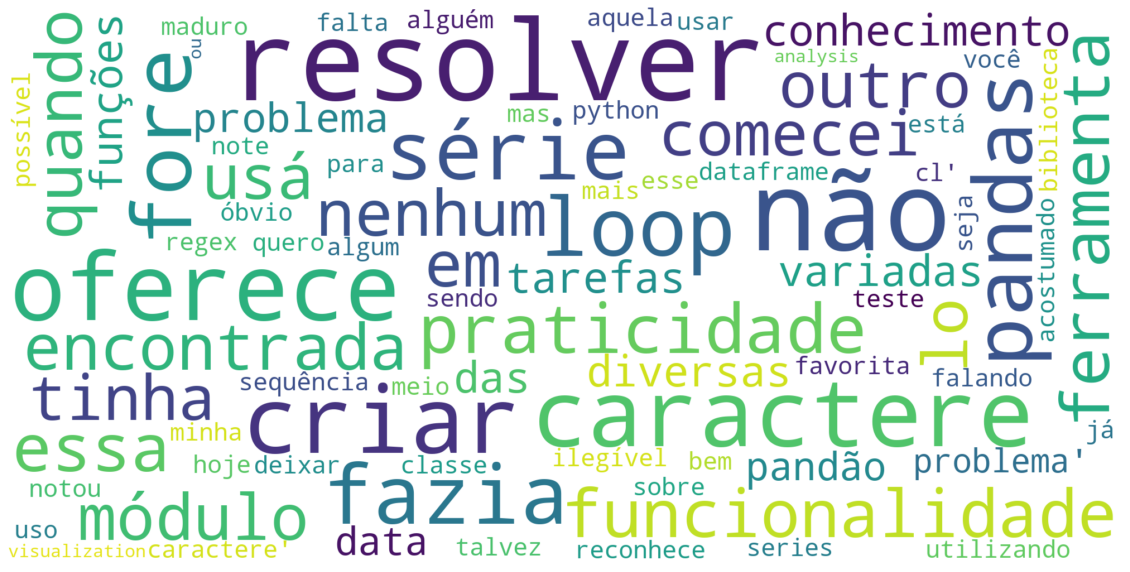

In [13]:
# Definição de palavras e caracteres indesejados

stopwords_materia = nltk.corpus.stopwords.words('portuguese')
repl_lst = [",","'",":",'"','#','!','?','.', '{','}','[',']', 'para', 'uma', 'que', 'de']

# Texto para Nuvem de Palavras

frase = UnionText(col_text)

# Config Nuvem 

nuvem = WordCloud(min_font_size=20, 
               max_font_size=200, 
               background_color='white', 
               mode="RGB",
               width=2000, 
               height=1000,
               normalize_plurals= True,
               collocations=False)

plt.figure(figsize=(20, 20))
nuvem.generate(frase)
plt.axis("off")
plt.imshow(nuvem, interpolation="bilinear")
